# 텍스트 요약 실습

## 학습 목표
- Extractive/Abstractive summarization 이해하기
- 단어장 크기를 줄이는 다양한 text normalization 적용해보기
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

## 텍스트 요약(Text Summarization)이란?

- Document 원문을 핵심 주제만으로 구성된 짧은 Summary 문장들로 변화하는 것을 말한다.
-  예)뉴스 기사로 뉴스 제목 생성
- 요약 전후에 정보 손실 발생이 최소화 되어야 한다

### 추출적 요약(Extractive Summarization)
- 원문에서 __문장들을 추출__해서 요약하는 방식
- 예)10개의 문장으로 구성된 텍스트에서 핵심적인 문장 3개를 꺼내온다
- Text Classification 문제로 볼 수 있다
- 문장들 간의 호응이 자연스럽지 않을 수 있다
- 주로 ML인 텍스트 랭크(TextRank) 같은 알고리즘을 사용한다
- 사례)네이버 뉴스 서비스 요약봇

![요약봇](https://media.vlpt.us/images/dev_halo/post/fc1bf96f-0877-4db1-a4ee-a4a67f3e9c6c/20171128000144_0640.png)

### 추상적 요약(Abxtractive Summarization)
- 원문에서 내용이 요약된 __새로운 문장을 생성__하는 방식
- Natural Language Generation의 영역

### Seq2seq

- 두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로 부터 출력 시퀀스를 생성해내는 모델
- 원문을 encoder(1st RNN)으로 입력하면 하나의 고정된 벡터로 변환(context vector)
- decoder(2nd RNN)은 context vector을 입력으로 받아 한 단어씩 생성해내서 요약 문장을 완성한다.

- encoder, decoder로 __LSTM__을 사용 → time step의 셀에 hidden state와 cell state가 함께 전달(context vector에도 hidden state와 cell state 모두 존재)
- 데이터의 예측 대상 시퀀스의 앞, 뒤에는 __시작 토큰과 종료 토큰__을 넣어주는 전처리를 해주어 어디서 멈춰야 하는지를 알려줄 필요가 있다.
- __Attention Mechanism__은 encoder의 모든 step의 hidden state의 정보가 context vector에 전부 반영되도록 하는 것
- decoder의 현재 스텝에 따라 동적으로 달라지는 encoder의 context vector를 사용해서 현재의 예측에 활용하면, decoder가 좀 더 정확한 예측을 할 수 있게 된다.

***

In [45]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('=3')

=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 데이터 준비

[아마존 리뷰 데이터셋](https://www.kaggle.com/bittlingmayer/amazonreviews)

In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


학습에 사용될 Summary, Text 컬럼만 분리해 저장한다.

In [4]:
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
16957,The plant was healthy and looked just like the...,Carnivorous pitcher plant
1891,Got these at a fraction of the price that they...,Pop Chips...Yummy!
31422,"I use Spike on popcorn, veggies, meats, soups,...","Spike can be used on so many things, it's amaz..."
81875,I came across this PetSafe Lickety Stik and de...,Fantastic Product
96544,"Having always been partial to Barilla sauces, ...",Nice meal!
39747,Bought a pack of these since I saw them on sal...,My cat loves it.. I don't know if I do.
47831,This is the best vanilla extract I have ever t...,Excellent Vanilla Extract
78693,"Package arrived DOUBLE boxed, wrapped, and the...",Amazing Service
67383,MMMmmm.. Tasty!! Just wish these pumpkin popt...,Treat yourself to a slice of heaven:)
58312,"Very smooth and mild, no ""off"" tastes - but un...",Mild to the point of being Bland


Text 열의 내용을 요약한 게 Summay 내용이다. Text 시퀀스를 입력받으면, Summary 시퀀스를 예측하도록 인공 신경망을 훈련시킨다.

## 데이터 전처리

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
# 중복 샘플 유무 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [6]:
# 중복 샘플 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [7]:
# 데이터의 NULL값 확인
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
## NULL값 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


### 텍스트 정규화와 불용어 제거

__텍스트 정규화(Text normalization)__ : 같은 의미인데 다른 표현으로 쓰여 다른 단어로 간주되는 경우
학습전에 미리 같은 표현으로 통일 시켜주어 연산량을 줄인다.

[정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [9]:
# 텍스트 정규화를 위한 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


__불용어__: 텍스트에 자주 등장하지만 자연어 처리를 할 때 실질적으로 도움이 되지 않는 단어들

In [10]:
# LTK에서 제공하는 불용어 리스트를 참조
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
# 전처리 함수 결과 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [13]:
# 훈련 데이터 전체에 대해서 전처리를 수행

import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['Text'])
print(clean_text)

clean_summary = preprocess_data(data['Summary'], remove_stopwords=False) # 불용어를 제거를 하지 않습니다.
print(clean_summary)

257.8480975627899  seconds
['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo'
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch'
 ...
 'favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack'
 'like noodles although say spicy somewhat understatement one else family tolerates spicy well seeing looking forward extra little something palate disappointed completely honest usually drain liquid almost much'
 'love noodle twice week amazing thing feel well

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


6.141042232513428  seconds
['good quality dog food' 'not as advertised' 'delight says it all' ...
 'great ramen' 'spicy'
 'this spicy noodle cures my cold upset stomach and headache every time']


텍스트 정제 과정을 거친 후에는 빈 샘플이 생겼는지 확인해보는 게 좋다.

In [14]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [16]:
# 정제과정에서 생긴 Null값 삭제
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


## 훈련 데이터와 테스트 데이터 나누기

### 샘플의 최대 길이 정하기

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해본다

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


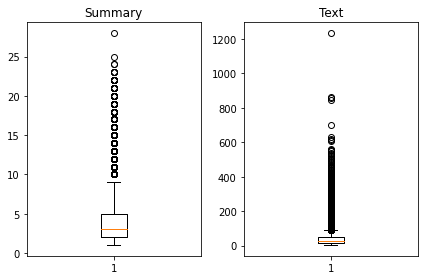

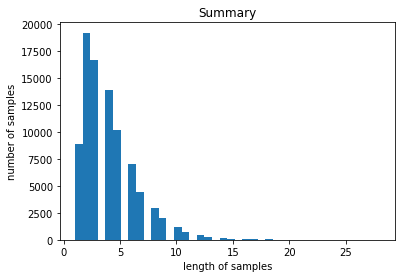

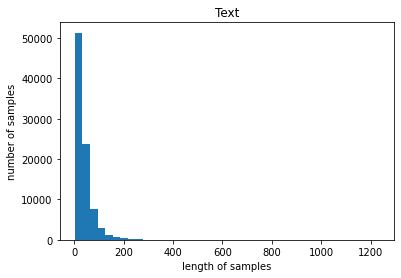

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
# ext의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정한다.
text_max_len = 50
summary_max_len = 8

In [19]:
# 길이를 선택했을 때, 얼만큼의 샘플을 포함할 수 있는지
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [21]:
# 정해진 길이보다 길면 제외한다.
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


### 시작 토큰과 종료 토큰 추가하기

In [22]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [23]:
# 인코더, 디코더의 입력과 레이블을 각각 Numpy 타입으로 저장한다.
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만든다.
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[34411 52000  1373 ... 24282 35578 42893]


In [25]:
#  정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 된다.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [26]:
# 훈련 데이터와 테스트 데이터 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [27]:
# 훈련 데이터
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]
# 테스트 데이터
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


## 정수 인코딩

### 단어 집합(vocabulary) 만들기 및 정수 인코딩

__단어 집합__: 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 만든다.

#### Text 데이터 정수 인코딩

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

단어 집합은 `src_tokenizer.word_index`에 저장되어 있다.
`src_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.

In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31965
등장 빈도가 6번 이하인 희귀 단어의 수: 23720
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8245
단어 집합에서 희귀 단어의 비율: 74.20616299077115
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3861640844305407


In [30]:
# 등장빈도가 6회 이하인 단어들은 훈련 데이터에서 제거
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

`texts_to_sequences()`는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[705, 3658, 16, 9, 74, 1783, 151, 3, 1150, 6454, 4, 412, 5, 6118, 3722, 26, 331, 265, 34, 208, 896, 705, 27, 106, 822, 1021, 604, 39], [180, 53, 227, 1033, 685, 1262, 206, 4924, 576, 951, 1048, 266, 122, 13, 480, 654, 951, 266, 569], [114, 36, 155, 185, 6, 134, 768, 3460, 17, 240, 3, 292, 1720]]


#### Summary 정수 인코딩

In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10536
등장 빈도가 5번 이하인 희귀 단어의 수: 8165
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2371
단어 집합에서 희귀 단어의 비율: 77.49620349278665
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.927576265562311


In [34]:
# 등장빈도가 5회 이하인 단어들은 훈련 데이터에서 제거
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 629], [1, 4, 87, 7, 5], [1, 28, 43, 360], [1, 21, 3], [1]]
target
decoder  [[629, 2], [4, 87, 7, 5, 2], [28, 43, 360, 2], [21, 3, 2], [2]]


In [35]:
# 빈도수가 낮은 단어가 삭제되어 생긴 빈 샘플 제거 (길이 1인 경우)
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1266
삭제할 테스트 데이터의 개수 : 337
훈련 데이터의 개수 : 51389
훈련 레이블의 개수 : 51389
테스트 데이터의 개수 : 12826
테스트 레이블의 개수 : 12826


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해준다. 

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 모델 설계하기

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### encoder 설계

In [38]:
# 인코더 설계 시작
embedding_dim = 128 # 임베딩 벡터의 차원
hidden_size = 256 # lstm에서 얼만큼의 수용력(capacity)를 가질지 정하는 파라미터

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### decoder 설계

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [40]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax') # tar_vocab에서 하나의 단어를 선택하는 다중 클래스 분류 문제
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 어텐션 매커니즘

In [41]:
# 구현된 어텐션 함수 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [42]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 훈련하기

#### 모델저장

In [46]:
checkpoint_path = "ex10/LSTM2.ckpt"             # 저장할 가중치의 확장자 및 파일 이름
checkpoint_dir = os.path.dirname(checkpoint_path)  # 저장할 경로

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, # 학습 시 callback함수를 반환하여 학습
                                                 save_weights_only=True,
                                                 verbose=1)

#### Early Stopping
모니터링 항목의 개선이 중지되면 학습을 중지하는 함수

|Args||
|------:|:---|
|monitor|모니터링 할 성능|
|patience|성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의|
|min_delta|개선의 자격을 갖추기 위해 모니터링되는 수량의 최소 변경, 즉 min_delta 미만의 절대 변경은 개선되지 않은 것으로 간주.|
|verbose|1 로 지정하면, 언제 keras 에서 training 을 멈추었는지를 화면에 출력|
|mode|{"auto", "min", "max"}, auto는 keras에서 알아서 min,max 선택,performance measure를 정의하고, 이것을 최대화 할지, 최소화 할지를 지정하는 것이다. 그러면 keras 에서 알아서 적절한 epoch 에서 training 을 멈춘다.|
|baseline|performance measure 를 practical 하게 설정한 경우 성능의 증가의 기준을 직접 정의. 모델이 기준선보다 개선되지 않으면 학습이 중지|
|restore_best_weights|모니터링된 수량의 최상의 값으로 에포크에서 모델 가중치를 복원할지 여부|

In [47]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
earlystopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[checkpoint ,earlystopping], epochs=50) # model.fit()에 callback으로 es객체를 넣어줘야 es 적용 가능

Epoch 1/50
201/201 [==============================] - 171s 789ms/step - loss: 3.1169 - val_loss: 2.4262

Epoch 00001: saving model to ex10/LSTM2.ckpt
Epoch 2/50
201/201 [==============================] - 161s 801ms/step - loss: 2.4178 - val_loss: 2.3174

Epoch 00002: saving model to ex10/LSTM2.ckpt
Epoch 3/50
201/201 [==============================] - 161s 800ms/step - loss: 2.2806 - val_loss: 2.1803

Epoch 00003: saving model to ex10/LSTM2.ckpt
Epoch 4/50
201/201 [==============================] - 162s 808ms/step - loss: 2.1582 - val_loss: 2.0882

Epoch 00004: saving model to ex10/LSTM2.ckpt
Epoch 5/50
201/201 [==============================] - 161s 804ms/step - loss: 2.0581 - val_loss: 2.0420

Epoch 00005: saving model to ex10/LSTM2.ckpt
Epoch 6/50
201/201 [==============================] - 161s 803ms/step - loss: 1.9850 - val_loss: 1.9899

Epoch 00006: saving model to ex10/LSTM2.ckpt
Epoch 7/50
201/201 [==============================] - 162s 805ms/step - loss: 1.9341 - val_loss: 1.9

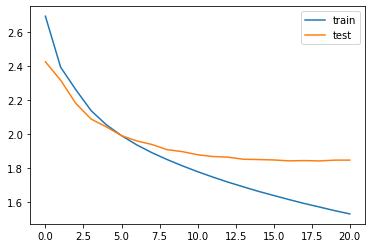

In [48]:
# 훈련 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기

> __인퍼런스란?__
학습을 마친 모델로 실제 과제를 수행하는 행위 혹은 그 과정

In [49]:
# 정수로 된 데이터를 실제로 복원해야 하므로 필요한 사전을 세팅한다.
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

- Seq2seq는 훈련할 때와 인퍼런스 단계의 방식이 달라 그에 맞는 모델 설계를 별개로 진행해야 한다
- 훈련 단계: 인코더와 디코더를 엮은 모델 준비
- 인퍼런스 단계: 인코더 모델과 디코더 모델을 분리해서 설계(정답X, 디코더가 반복구조로 동작할 필요)

In [50]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [51]:
# 어텐션 메커니즘을 사용하는 출력층 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [52]:
# 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트하기

In [53]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [54]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : really love cheez sit front tv box know half gone different know expected little box yet seemed fall short nail directly head get wrong still enjoyed left odd taste mouth honestly crazy much else say hope review helped one way enjoy 
실제 요약 : an okay taste from delicious brand 
예측 요약 :  not as pictured


원문 : received packet gold gourmet hot chocolate sample bland bitter slight mushroom smell aftertaste understand type mushroom expect forward drink neither sweet enough enjoyable lighter chocolate drink rich enough good dark chocolate drink really would recommend give two stars completely undrinkable close 
실제 요약 : weak flavor unusual smell 
예측 요약 :  not for me


원문 : trying lose pounds weight watchers best chips around love potatoes keep diet tasty low fat oil boyfriend diet also enjoys chips yum 
실제 요약 : these rock 
예측 요약 :  great snack


원문 : local grocery stores started stocking chewy kashi breakfast bars husband went absolute favorite kashi crunchy honey toasted grain eaten ban

***

## 추출적 요약 해보기

매트릭스 시놉시스를 `Summa`의 추출적 요약 모듈인 summarize를 이용해 요약해본다.

### 데이터 준비

In [55]:
import requests
from summa.summarizer import summarize

In [56]:
# 매트릭스 시놉시스 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [57]:
# 내용 확인
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기

#### summa의 summarize()

|Args||
|:------|:---|
|text (str)|요약할 테스트|
|ratio (float, optional)|요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값|
|words (int or None, optional)|출력에 포함할 단어 수.만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.|
|split (bool, optional)|True면 문장 list / False는 조인(join)된 문자열을 반환|

* 내부적으로 문장토큰화 수행

In [58]:
print('Summary:')
print(summarize(text, ratio=0.005)) # 요약문으로 선택되는 문장의 개수, 원문의 0.005%만을 출력

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [59]:
# 리스트로 결과 출력
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [60]:
# 50개의 단어로 요약문의 크기 조정
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
